In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

In [44]:
torch.manual_seed(42)

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [46]:
df = pd.read_csv('./fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [47]:
df.shape

(6000, 785)

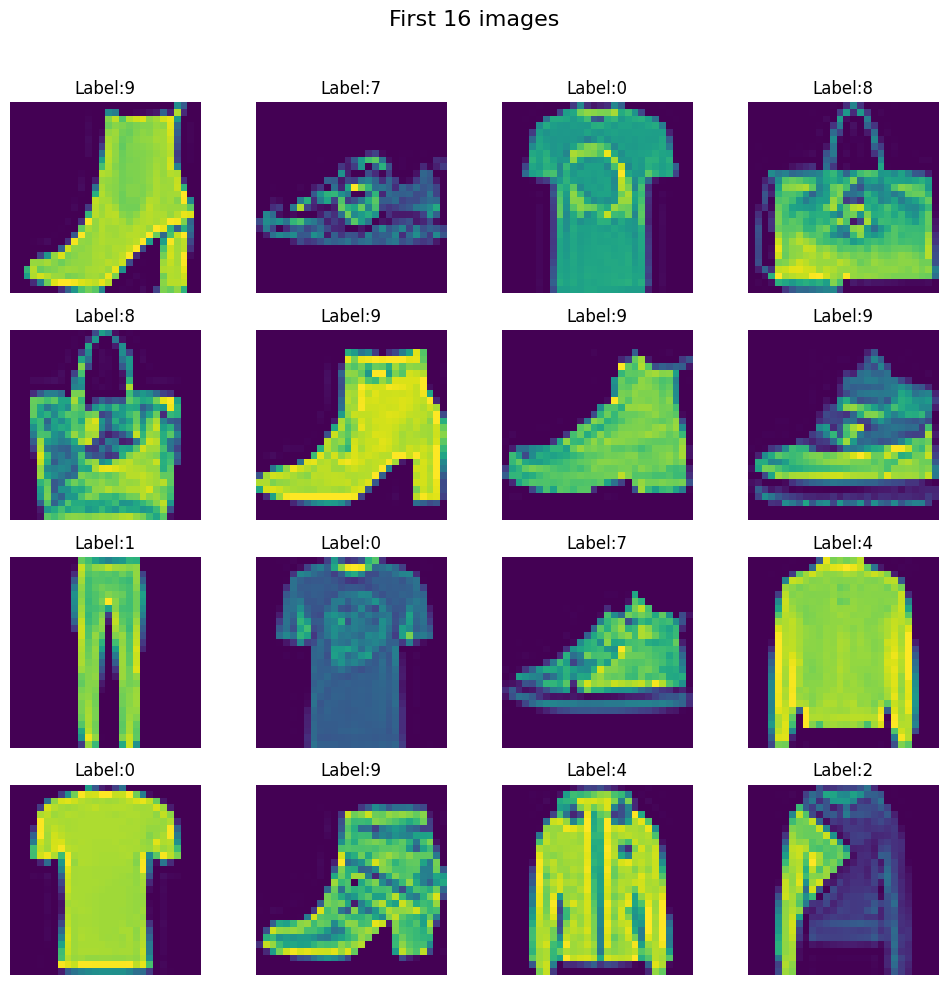

In [48]:
# create a 4x4 grid of images
fig,axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images",fontsize=16)
# plot the first 16 images from the dataset
for i,ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label:{df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [49]:
# train test split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [51]:
from torchvision.transforms import transforms
custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [52]:
from PIL import Image
import numpy as np
class CustomDataset(Dataset):
  def __init__(self,features,labels,transform):
    self.features = features
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    # resize the image to (28,28)
    image = self.features[index].reshape(28,28)
    # change the datatype to unit8
    image = image.astype(np.uint8)
    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3,axis=-1)
    # convert array to PIL image
    image = Image.fromarray(image)
    # apply the transformations
    image = self.transform(image)
    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

In [53]:
train_dataset = CustomDataset(X_train,y_train,transform=custom_transform)

In [54]:
test_dataset = CustomDataset(X_test,y_test,transform=custom_transform)

In [55]:
train_loader = DataLoader(train_dataset,batch_size = 32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size = 32,shuffle=False,pin_memory=True)

In [56]:
# fetch the pretrained model
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [58]:
for param in vgg16.features.parameters():
  param.requires_grad=False


In [59]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [60]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [61]:
vgg16 = vgg16.to(device)

In [62]:
learning_rate = 0.0001
epochs = 10

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(),lr=learning_rate)

In [64]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = vgg16(batch_features)

    print(outputs.shape)
    print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

    break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


torch.Size([32, 10])
torch.Size([32])
Epoch: 1 , Loss: 0.015262775421142578
torch.Size([32, 10])
torch.Size([32])
Epoch: 2 , Loss: 0.01541195551554362
torch.Size([32, 10])
torch.Size([32])
Epoch: 3 , Loss: 0.015226322809855143
torch.Size([32, 10])
torch.Size([32])
Epoch: 4 , Loss: 0.014337010383605957
torch.Size([32, 10])
torch.Size([32])
Epoch: 5 , Loss: 0.013862826029459636
torch.Size([32, 10])
torch.Size([32])
Epoch: 6 , Loss: 0.013183937072753907
torch.Size([32, 10])
torch.Size([32])
Epoch: 7 , Loss: 0.013026554584503174
torch.Size([32, 10])
torch.Size([32])
Epoch: 8 , Loss: 0.01277344544728597
torch.Size([32, 10])
torch.Size([32])
Epoch: 9 , Loss: 0.012517779668172201
torch.Size([32, 10])
torch.Size([32])
Epoch: 10 , Loss: 0.011623485088348389


In [66]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [67]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.5716666666666667


In [69]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.5908333333333333
